# Übung: Semantische Segmentierung von intergranularen Brüchen aus  Bilddaten

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from fastai.vision.all import * 
import fastai
import torch
print("sys.version", sys.version)
print("cuda device name(0)", torch.cuda.get_device_name(0))
print("torch.__version__", torch.__version__)
print("fastai.__version__", fastai.__version__)

sys.version 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
cuda device name(0) Tesla V100S-PCIE-32GB
torch.__version__ 1.7.1
fastai.__version__ 2.5.3


In [3]:
import pathlib
path = Path('./volumes')

## Datensatz laden

In [4]:
from PIL import Image
import numpy

def get_tif_images(file_path):
    files = get_image_files( file_path )
    files =  [file for file in files if "_BSE_" in str(file)]
    return files

def load_multislice_tif(file_path, max_slices):
    image = Image.open(file_path)
    h,w = numpy.shape( image )
    n_frames = image.n_frames
    if n_frames>max_slices:
        n_frames = max_slices
    imagelist = [] 
    for i in range(n_frames):
        image.seek(i)
        imagelist.append( PILImage.create( numpy.array( image ) ) )
    return imagelist; 

def int2float(o:TensorImage):
    # print("executing int2float")
    o = o * 255.0
    return o.float()

class MultiSliceImage():
    def __init__(self, data):
        self.data = data
   
    @classmethod
    def create_multi( cls, file_path):
        return cls( load_multislice_tif(file_path, 256) )
    
    @classmethod
    def create_single( cls, file_path):
        return cls( load_multislice_tif(file_path, 1) )
        
def MultiSliceImageBlock(): 
    return TransformBlock(type_tfms  = MultiSliceImage.create_single,
                          batch_tfms = int2float) 

def MultiSliceMaskBlock(): 
    return TransformBlock(type_tfms  = MultiSliceImage.create_multi) 
       
def get_x( filename ):
    filename_parts = str(filename.stem).split("_")
    y = path / Path( "_".join(filename_parts[:-2]) + "_GT_" + filename_parts[-1] + ".tif" )
    return y

def get_y( filename ):
    return filename

In [5]:
import traceback

class SequenceTfms(Transform):
    def __init__(self, tfms): 
        self.tfms = tfms
        
    def encodes(self, x: MultiSliceImage):
        try:
            for transform in self.tfms:
                if len(x.data) > 1:
                    transform.before_call( x.data[0], None )
                for i in range(len(x.data)):
                    x.data[i] = transform.encodes( x.data[i] )
        except Exception:
            print(traceback.format_exc())   
        return x

In [6]:
from torchvision import transforms

datablock = DataBlock(
    blocks     = ( MultiSliceMaskBlock, MultiSliceImageBlock ),
    get_items  = get_tif_images, 
    get_x      = get_x,
    get_y      = get_y,
    splitter   = RandomSplitter(),
    item_tfms  = SequenceTfms( [ RandomCrop(256) ] ),
    batch_tfms = SequenceTfms( [ Rotate(max_deg=360) ] )
)

def create_batch(data):
    try:
        x,y = data[0]
        x = torch.cat( [transforms.ToTensor()(image) for image in x.data] )       
        x = torch.unsqueeze( x, dim=0 )       
        x = torch.unsqueeze( x, dim=0 )       
        y = transforms.ToTensor()(y.data[0])
        y = torch.unsqueeze( y, dim=0 )        
        y = torch.unsqueeze( y, dim=0 )        
        y = TensorImage(y)
        # print("create batch x", x.shape, "y", y.shape)
        # print("create batch x", x[0][0], x[0][0].cpu())
        # print("create batch y", y.shape, "y", y.shape)
        # print("create batch y", y[0][0], y[0][0].cpu())
        return TensorMask(x),TensorImage(y)
    except Exception as err:
        traceback.print_tb(err.__traceback__)
        
data_loader = datablock.dataloaders(source = path, bs=1, create_batch=create_batch)

y-batch TensorImage([[116., 140., 142.,  ..., 109.,  98., 107.],
        [134., 125., 126.,  ..., 110., 113., 121.],
        [126., 142., 136.,  ..., 107., 111., 104.],
        ...,
        [120., 116., 115.,  ..., 110., 109., 119.],
        [108., 118., 150.,  ..., 115., 100., 123.],
        [114., 120., 116.,  ..., 115., 122., 112.]])


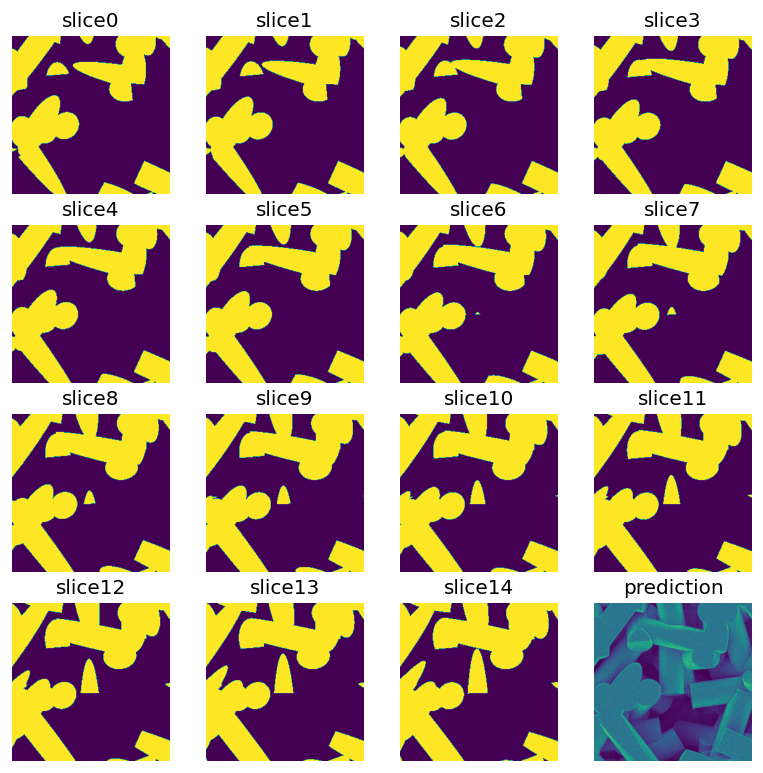

In [7]:
def show_sequence_batch(data_loader, max_n=1):
    xbatch, ybatch = data_loader.one_batch()
    to_display = min( xbatch.shape[2], 16 )
    # print("showing batch",xbatch.shape,to_display)
    ncols = int( math.sqrt( to_display ) )
    nrows = int( math.sqrt( to_display ) )
    fig, axes = plt.subplots(ncols=ncols, nrows=ncols, figsize=(8,8), dpi=120)
    # print("x-batch",xbatch[0][0][0].cpu())
    for a in range( ncols ):
        for b in range( nrows ):
            i = b * ncols + a
            xs = xbatch[0][0][i]
            axes[b,a].imshow(xs.cpu().numpy())
            axes[b,a].set_title("slice" + str(i) )
            axes[b,a].axis('off')
    
    ys = ybatch[0][0][0]
    print("y-batch",ybatch[0][0][0].cpu())
    axes[nrows-1,nrows-1].imshow(ys.cpu().numpy())
    axes[nrows-1,nrows-1].set_title( "prediction" )
    axes[nrows-1,nrows-1].axis('off')
            
show_sequence_batch(data_loader)            

## Netzwerk Modell

In [8]:
def build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block ):
    layers = []
    for i in range(conv_per_block):
        in_f = mid_features
        if i == 0:
            in_f = in_features
        out_f = mid_features
        if i == conv_per_block-1:
            out_f = out_features
        kernel_x, kernel_y, kernel_z = kernel_size
        pad = (int(kernel_x/2),int(kernel_y/2),int(kernel_z/2))
        layers.append( ("Conv"+str(i), nn.Conv3d(in_f,out_f,kernel_size,padding=pad,padding_mode='replicate') ) )
        layers.append( ("ReLU"+str(i), nn.ReLU() ) )
    return torch.nn.Sequential( OrderedDict( layers ) )    

class EncoderBlock(torch.nn.Module):
    def __init__(self, in_features, mid_features, out_features, kernel_size, conv_per_block ):
        super().__init__()
        self.conv_layers = build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block )
        self.pool  = torch.nn.MaxPool3d(2)
    
    def forward(self, x):
        hr_values = torch.clone(x)
        x = self.conv_layers(x)
        x = self.pool(x)
        # print("encoding to ", x.shape, "high_res", hr_values.shape)
        return x, hr_values

class DecoderBlock(torch.nn.Module):
    def __init__(self, in_features, mid_features, out_features, kernel_size, conv_per_block ):
        super().__init__()
        self.upsampling = torch.nn.Upsample(scale_factor=2 )
        self.conv_layers = build_conv_block( in_features, mid_features, out_features, kernel_size, conv_per_block )
    
    def forward(self, x, hr_values):
        x = self.upsampling(x)
        # print("decoding upsamples to", x.shape, "high_res", hr_values.shape)        
        x = torch.cat( (x,hr_values), 1 )
        x = self.conv_layers(x)
        return x
    
class MonteCarloUNet(torch.nn.Module):
    def __init__(self, n_features = 16, kernel_size = (3,3,3), conv_per_block = 1):
        super().__init__()
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.conv_per_block = conv_per_block
        self.encoder_blocks = torch.nn.Sequential( OrderedDict( [ 
                                ( "Encoder1", EncoderBlock(1,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder2", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder3", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder4", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder5", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder6", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Encoder7", EncoderBlock(n_features,n_features,n_features,kernel_size,conv_per_block) )] ) )
        self.decoder_blocks = torch.nn.Sequential( OrderedDict( [ 
                                ( "Decoder1", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder2", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder3", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder4", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder5", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder6", DecoderBlock(2*n_features,n_features,n_features,kernel_size,conv_per_block) ),
                                ( "Decoder7", DecoderBlock(n_features+1,n_features,1,kernel_size,conv_per_block) ) ] ) )

    def forward(self, x):
        values  = []
        for encoder in self.encoder_blocks:
            x, hr_values = encoder( x )
            values.append( hr_values )
            
        values.reverse()
            
        for i, decoder in enumerate( self.decoder_blocks ):
            highres_values = values[i]
            x = decoder( x, highres_values )

        output = x[:,:,0,:,:]
        # print("forward output", output[0][0][0].cpu())
        return x[:,:,0,:,:]       

    def name(self):
        return "MCNet_width_" + str(self.n_features) + "_depth_" + str(14*self.conv_per_block) + "_kernel_" + str(self.kernel_size)

In [9]:
class ImageAndMaskMSELoss(nn.MSELoss):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(ImageAndMaskMSELoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        input = TensorBase(input)
        target = target.squeeze(0)
        target = TensorBase(target)
        # print("loss function input", input.shape, input)
        # print("loss function target", target.shape, target)
        return super(ImageAndMaskMSELoss,self).forward(input, target)

In [10]:
# learner.lr_find()

In [11]:
gewaehlteLernrate = 0.0001

In [12]:
def show_preds(preds,target, max_n=1, filename = None):   
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), dpi=120)
       
    for i in range(2):
        preds_i = preds[i,:,:,:].squeeze(0)    
        target_i = target[i,:,:,:,:].squeeze(0).squeeze(0)   
        
        axes[i,0].imshow(preds_i.cpu().numpy())
        axes[i,0].set_title("prediction")
        axes[i,0].axis('off')

        axes[i,1].imshow(target_i.cpu().numpy())
        axes[i,1].set_title("target")
        axes[i,1].axis('off')
        
        if not filename is None:
            print("saving to ",filename)
            plt.savefig(filename)

MCNet_width_32_depth_28_kernel_(7, 3, 3)


epoch,train_loss,valid_loss,time
0,10622.571289,13420.435547,01:15
1,10552.573242,13002.921875,00:45
2,10491.308594,11852.696289,00:45
3,10432.705078,11802.369141,00:46
4,10310.066406,12400.373047,00:45
5,10234.143555,13740.115234,00:46
6,10185.781250,12716.221680,00:46
7,10206.165039,12449.187500,00:46
8,10190.970703,12655.891602,00:46
9,9655.277344,6990.177246,00:46


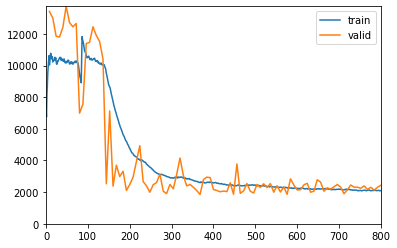

saving to  results/MCNet_width_32_depth_28_kernel_(7, 3, 3)_100_epochs.png
saving to  results/MCNet_width_32_depth_28_kernel_(7, 3, 3)_100_epochs.png
MCNet_width_32_depth_14_kernel_(7, 3, 3)


epoch,train_loss,valid_loss,time
0,10457.688477,12019.770508,00:23
1,10271.379883,12241.886719,00:17
2,10275.930664,13927.281250,00:17
3,10231.503906,12417.806641,00:16
4,10199.447266,12734.398438,00:17
5,10238.536133,13350.726562,00:17
6,10236.461914,13288.161133,00:17
7,10205.558594,12266.658203,00:17
8,10130.379883,13046.917969,00:16
9,9618.750977,7671.308594,00:16


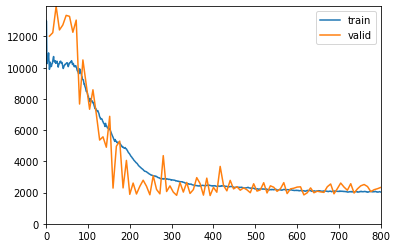

saving to  results/MCNet_width_32_depth_14_kernel_(7, 3, 3)_100_epochs.png
saving to  results/MCNet_width_32_depth_14_kernel_(7, 3, 3)_100_epochs.png
MCNet_width_32_depth_28_kernel_(5, 3, 3)


epoch,train_loss,valid_loss,time


RuntimeError: CUDA out of memory. Tried to allocate 2.06 GiB (GPU 0; 31.75 GiB total capacity; 25.70 GiB already allocated; 1.30 GiB free; 29.33 GiB reserved in total by PyTorch)

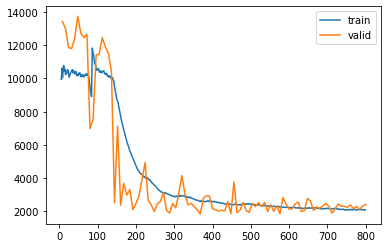

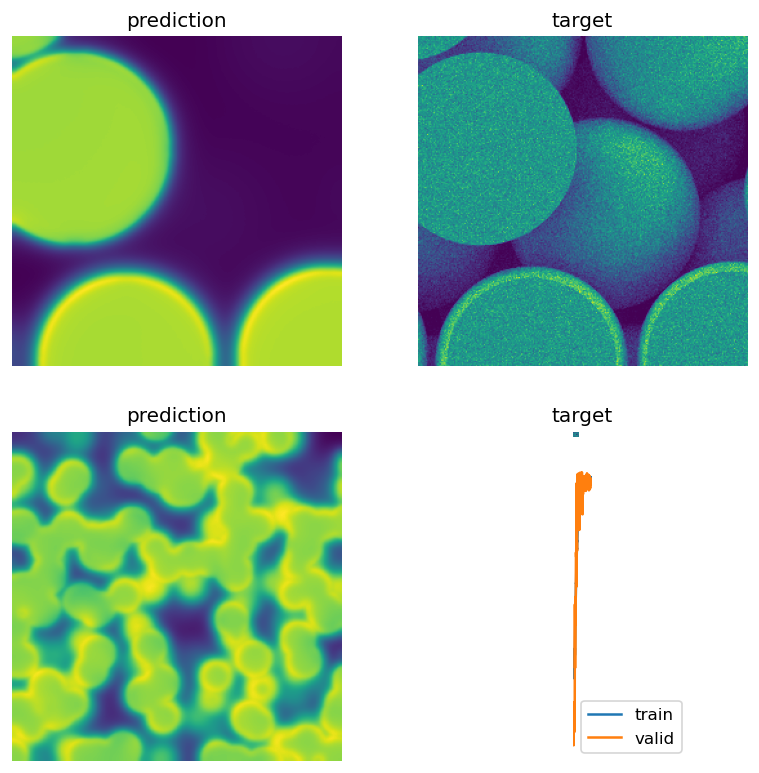

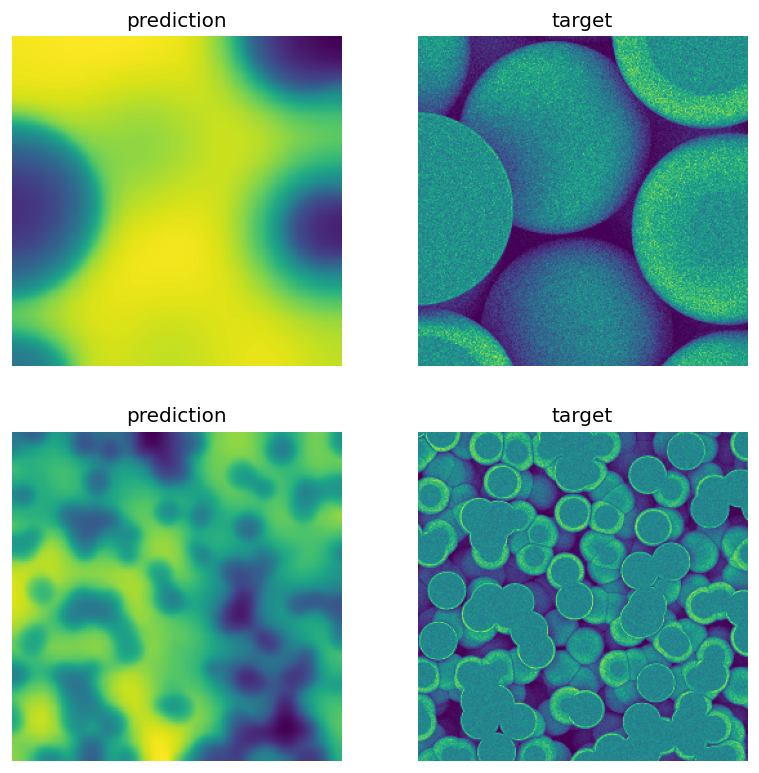

In [13]:
from torchinfo import summary

for n_features in [128,32,4]:
    for kernel_size in [(7,3,3),(3,3,3)]:
        for conv_per_block in [2,1]:            
            model = MonteCarloUNet( n_features, kernel_size, conv_per_block )            
            print( model.name() )
            # print( summary(model, input_size=(1, 1, 128, 128, 128), device="cpu") )
            learner = Learner( data_loader, model, ImageAndMaskMSELoss() )
            # print( learner.summary() )
            learner.fit_one_cycle(100, gewaehlteLernrate, cbs=[ShowGraphCallback()])
            learner.recorder.plot_loss()
            plt.savefig( 'results/' + model.name() + '_loss_plot.png')
            learner.save( model.name() + "_100_epochs")
            preds,targs = learner.get_preds()     
            show_preds(preds,targs, filename = 'results/' + model.name() + '_100_epochs.png')